In [1]:
import os
import re
import pandas as pd
import numpy as np
import xarray as xr
import scipy
import os
import glob
from scipy import interpolate
from mpl_toolkits.axes_grid1 import ImageGrid
from pyts.image import GramianAngularField
import matplotlib.pyplot as plt
from matplotlib import pyplot
from tensorflow import keras
from keras.layers.convolutional import Conv1D,MaxPooling1D
from keras.layers import LSTM, Dense,TimeDistributed,Flatten
from mpl_toolkits.basemap import Basemap, maskoceans
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler,MinMaxScaler,MaxAbsScaler,QuantileTransformer,PowerTransformer

In [2]:
data=np.load('C:/Akmal/Telyu/Telyu/TA/x-datavalue-4fitur_new.npy')
gfed = pd.read_csv('C:/Akmal/Telyu/Telyu/TA/Data/MergedData/GFED_LandCover_1998-2022.csv')
ERA5=pd.read_csv('Data/era5/era5_1998-2022.csv')
x= np.asarray(data)

In [3]:
data.shape

(289200, 8, 8)

In [4]:
gfed=gfed.drop(columns=['Unnamed: 0'])
ERA5=ERA5.drop(columns=['Unnamed: 0'])

In [5]:
ERA5.shape

(1156800, 7)

In [6]:
data.shape

(289200, 8, 8)

In [7]:
ERA5

,longitude,latitude,time,u10,d2m,t2m,tp
0,108.875,-1.625,1998-01-01 12:00:00,2.415798,296.842666,300.061608,2.235000e-04
1,108.875,-1.625,1998-01-07 12:00:00,-1.817947,296.806256,301.226298,2.114110e-06
2,108.875,-1.625,1998-01-14 12:00:00,1.162200,297.675313,300.790596,1.322354e-07
3,108.875,-1.625,1998-01-21 12:00:00,3.177801,297.082215,301.157536,3.598691e-05
4,108.875,-1.625,1998-02-01 12:00:00,0.419865,297.391156,301.009055,1.481815e-06
...,...,...,...,...,...,...,...
1156795,119.125,5.375,2022-11-21 12:00:00,-0.345835,297.676997,300.521277,4.799787e-04
1156796,119.125,5.375,2022-12-01 12:00:00,0.445432,297.051291,299.253139,1.843481e-04
1156797,119.125,5.375,2022-12-07 12:00:00,-1.599880,297.108722,299.491698,5.340981e-05
1156798,119.125,5.375,2022-12-14 12:00:00,0.607264,296.199166,301.335542,1.344416e-06


In [8]:
pos =ERA5.groupby(['longitude','latitude']).size().reset_index().rename(columns={0:'count'})

In [9]:
pos

,longitude,latitude,count
0,108.875,-1.625,1200
1,109.125,-0.375,1200
2,109.125,-0.125,1200
3,109.125,0.375,1200
4,109.125,0.625,1200
...,...,...,...
959,119.125,-2.875,1200
960,119.125,-2.625,1200
961,119.125,-2.375,1200
962,119.125,5.125,1200


In [31]:
gfed.groupby(['longitudes','latitudes']).size().reset_index().rename(columns={0:'count'})

,longitudes,latitudes,count
0,108.875,-1.625,300
1,109.125,-0.375,300
2,109.125,-0.125,300
3,109.125,0.375,300
4,109.125,0.625,300
...,...,...,...
959,119.125,-2.875,300
960,119.125,-2.625,300
961,119.125,-2.375,300
962,119.125,5.125,300


<Axes: >

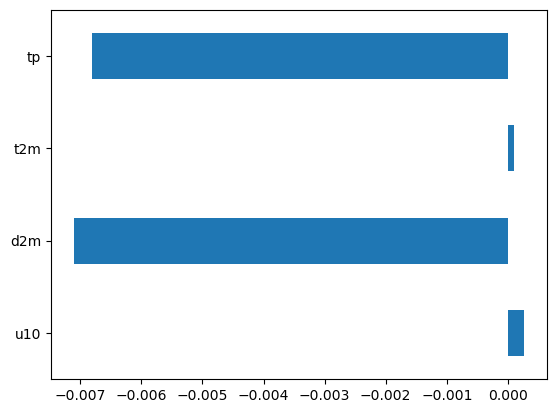

In [63]:
ERA5[['u10','d2m','t2m','tp']].corrwith(gfed['emissions']).plot(kind='barh')

In [52]:
data

<PandasArray>
[0.00027089523039227443,  -0.007109670252618684,   9.21140222071593e-05,
  -0.006799930023620388]
Length: 4, dtype: float64

In [19]:
# ERA5['time'] = pd.to_datetime(ERA5['time'])
# ERA5['month'] = ERA5['time'].dt.month/12
# ERA5['year'] = (ERA5['time'].dt.year-1997)/25
# ERA5['week'] = np.tile([1/4,2/4,3/4,4/4],int(len(ERA5)/4))
# # ERA5['longitude'] = -1+2.*(ERA5['longitude']-ERA5['longitude'].min())/(ERA5['longitude'].max()-ERA5['longitude'].min())
# # ERA5['latitude'] = -1+2.*(ERA5['latitude']-ERA5['latitude'].min())/(ERA5['latitude'].max()-ERA5['latitude'].min())
# ERA5.head()

In [18]:
print(min(gfed['longitudes']),min(ERA5['longitude']),max(gfed['latitudes']),max(ERA5['latitude']))

108.875 108.875 6.125 6.125


In [20]:
y = np.array(gfed['emissions'])

In [21]:
int(y.shape[0])/300

964.0

In [22]:
data.shape

(289200, 8, 8)

Text(0.5, 1.0, '8x8 Matrix for ERA5 dataset')

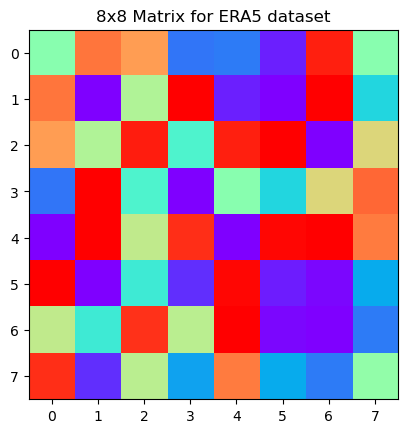

In [23]:
plt.imshow(data[0], cmap='rainbow')
plt.title('8x8 Matrix for ERA5 dataset')

In [24]:
x_train,x_test=[data[k*300:(k+1)*300-36] for k in range(int(data.shape[0]/300))],[data[(k+1)*300-36:(k+1)*300] for k in range(int(data.shape[0]/300))]
y_train,y_test=[y[k*300:(k+1)*300-36] for k in range(int(y.shape[0]/300))],[y[(k+1)*300-36:(k+1)*300] for k in range(int(y.shape[0]/300))]

In [25]:
x_train,x_test=np.array(x_train),np.array(x_test)
y_train,y_test=np.array(y_train),np.array(y_test)
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(964, 264, 8, 8) (964, 36, 8, 8) (964, 264) (964, 36)


In [26]:
x_train,x_test=x_train[14],x_test[14]
y_train,y_test=y_train[14],y_test[14]

In [18]:
# x_train,x_test=x_train.reshape(964*264,8,8),x_test.reshape(964*36,8,8)
# y_train,y_test=y_train.reshape(964*264),y_test.reshape(964*36)

# Testing Model

In [19]:
# reshape input to be 3D [samples, timesteps, features]
model = keras.models.Sequential()
model.add(LSTM(36, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam', metrics='accuracy')
model.summary()
# fit network
history = model.fit(x_train, y_train, batch_size=36, epochs=500, validation_data=(x_test, y_test), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('LSTM Prediction Loss')
pyplot.legend()
pyplot.show()
yhat = model.predict(x_test)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 36)                6480      
                                                                 
 dense (Dense)               (None, 1)                 37        
                                                                 
Total params: 6,517
Trainable params: 6,517
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
8/8 - 4s - loss: 5.4775 - accuracy: 0.6477 - val_loss: 0.1151 - val_accuracy: 0.6667 - 4s/epoch - 530ms/step
Epoch 2/500
8/8 - 0s - loss: 5.4633 - accuracy: 0.6477 - val_loss: 0.1093 - val_accuracy: 0.6667 - 147ms/epoch - 18ms/step
Epoch 3/500
8/8 - 0s - loss: 5.4547 - accuracy: 0.6477 - val_loss: 0.1065 - val_accuracy: 0.6667 - 135ms/epoch - 17ms/step
Epoch 4/500
8/8 - 0s - loss: 5.4494 - accuracy: 0.6477 - val_loss: 0.1036 - val_acc

KeyboardInterrupt: 

In [ ]:
predict_lstm=np.array(yhat[:,0])
actual_lstm=np.array(y_test)

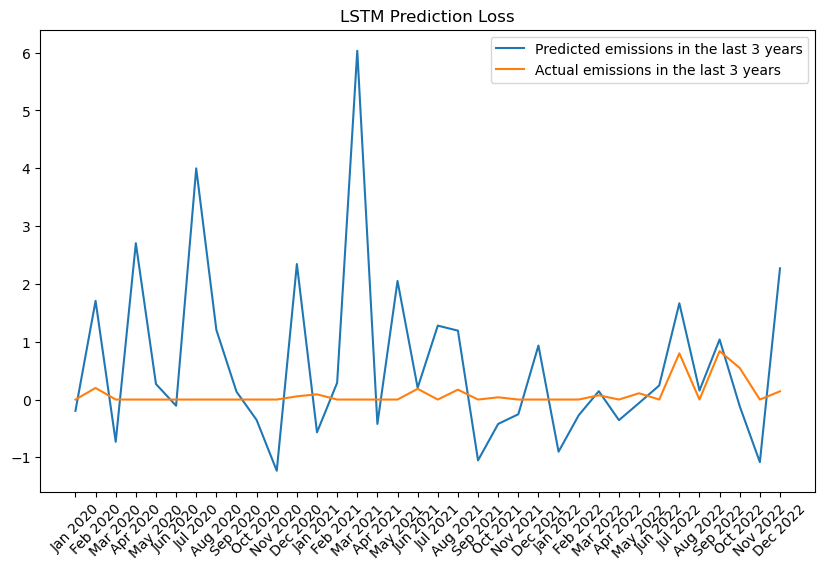

In [ ]:
pyplot.figure(figsize=(10,6))
pyplot.plot(yhat, label='Predicted emissions in the last 3 years')
pyplot.plot(y_test, label='Actual emissions in the last 3 years')
pyplot.xticks(np.arange(36), ['Jan 2020', 'Feb 2020', 'Mar 2020', 
                              'Apr 2020', 'May 2020', 'Jun 2020', 
                              'Jul 2020', 'Aug 2020', 'Sep 2020', 
                              'Oct 2020', 'Nov 2020', 'Dec 2020',
                              'Jan 2021', 'Feb 2021', 'Mar 2021', 
                              'Apr 2021', 'May 2021', 'Jun 2021', 
                              'Jul 2021', 'Aug 2021', 'Sep 2021', 
                              'Oct 2021', 'Nov 2021', 'Dec 2021',
                              'Jan 2022', 'Feb 2022', 'Mar 2022', 
                              'Apr 2022', 'May 2022', 'Jun 2022', 
                              'Jul 2022', 'Aug 2022', 'Sep 2022', 
                              'Oct 2022', 'Nov 2022', 'Dec 2022'], rotation=45)
pyplot.title('LSTM Prediction Loss')
pyplot.legend()
pyplot.show()

In [27]:
x_train,x_test=x_train.reshape(x_train.shape[0],8,8,1),x_test.reshape(x_test.shape[0],8,8,1)

In [ ]:
x_train.shape

(264, 8, 8, 1)

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_42 (TimeDi  (None, None, 8, 64)      128       
 stributed)                                                      
                                                                 
 time_distributed_43 (TimeDi  (None, None, 4, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_44 (TimeDi  (None, None, 256)        0         
 stributed)                                                      
                                                                 
 lstm_18 (LSTM)              (None, 50)                61400     
                                                                 
 dense_18 (Dense)            (None, 1)                 51        
                                                     

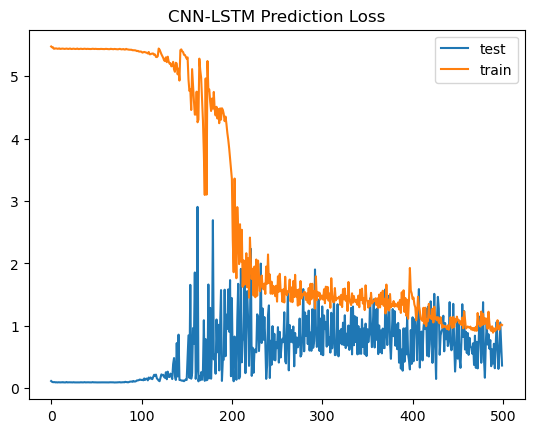

2/2 [==============================] - 0s 5ms/step


In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None,x_train.shape[2], x_train.shape[3])))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
# model.add(keras.layers.Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mae', metrics='accuracy')
model.summary()
history = model.fit(x_train, y_train, epochs=500, batch_size=32, validation_data=(x_test, y_test), verbose=2, shuffle=False)
# fit model
# model.fit(x_train, y_train, epochs=150, verbose=0)
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.title('CNN-LSTM Prediction Loss')
pyplot.legend()
pyplot.show()

yhat = model.predict(x_test)

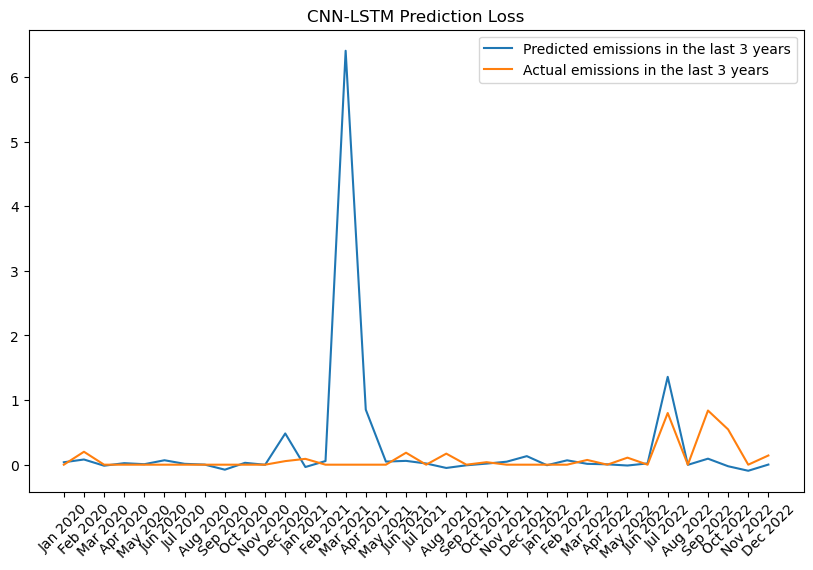

In [ ]:
pyplot.figure(figsize=(10,6))
pyplot.plot(yhat, label='Predicted emissions in the last 3 years')
pyplot.plot(y_test, label='Actual emissions in the last 3 years')
pyplot.xticks(np.arange(36), ['Jan 2020', 'Feb 2020', 'Mar 2020', 
                              'Apr 2020', 'May 2020', 'Jun 2020', 
                              'Jul 2020', 'Aug 2020', 'Sep 2020', 
                              'Oct 2020', 'Nov 2020', 'Dec 2020',
                              'Jan 2021', 'Feb 2021', 'Mar 2021', 
                              'Apr 2021', 'May 2021', 'Jun 2021', 
                              'Jul 2021', 'Aug 2021', 'Sep 2021', 
                              'Oct 2021', 'Nov 2021', 'Dec 2021',
                              'Jan 2022', 'Feb 2022', 'Mar 2022', 
                              'Apr 2022', 'May 2022', 'Jun 2022', 
                              'Jul 2022', 'Aug 2022', 'Sep 2022', 
                              'Oct 2022', 'Nov 2022', 'Dec 2022'], rotation=45)
pyplot.title('CNN-LSTM Prediction')
pyplot.legend()
pyplot.show()

In [ ]:
a=[]
b=[]
predict=np.array(yhat[:,0])
actual=np.array(y_test)
for i in range(len(y_test)):
    error_lstm=abs(predict_lstm[i]-actual_lstm[i])
    error=abs(predict[i]-actual[i])
    a.append(error_lstm)
    b.append(error)

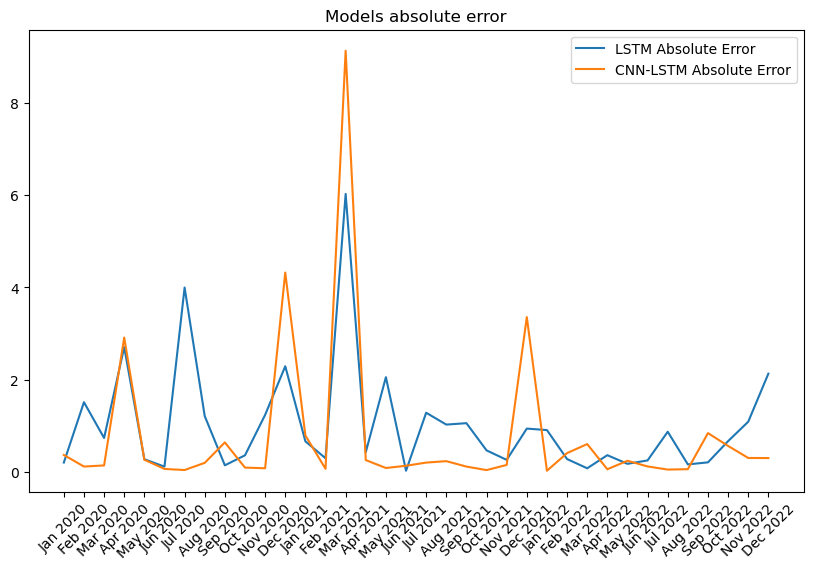

In [ ]:
pyplot.figure(figsize=(10,6))
pyplot.plot(a, label='LSTM Absolute Error')
pyplot.plot(b, label='CNN-LSTM Absolute Error')
pyplot.xticks(np.arange(36), ['Jan 2020', 'Feb 2020', 'Mar 2020', 
                              'Apr 2020', 'May 2020', 'Jun 2020', 
                              'Jul 2020', 'Aug 2020', 'Sep 2020', 
                              'Oct 2020', 'Nov 2020', 'Dec 2020',
                              'Jan 2021', 'Feb 2021', 'Mar 2021', 
                              'Apr 2021', 'May 2021', 'Jun 2021', 
                              'Jul 2021', 'Aug 2021', 'Sep 2021', 
                              'Oct 2021', 'Nov 2021', 'Dec 2021',
                              'Jan 2022', 'Feb 2022', 'Mar 2022', 
                              'Apr 2022', 'May 2022', 'Jun 2022', 
                              'Jul 2022', 'Aug 2022', 'Sep 2022', 
                              'Oct 2022', 'Nov 2022', 'Dec 2022'], rotation=45)
pyplot.title('Models absolute error')
pyplot.legend()
pyplot.show()

# Modelling per location

In [ ]:
x_train,x_test=[data[k*300:(k+1)*300-36] for k in range(int(data.shape[0]/300))],[data[(k+1)*300-36:(k+1)*300] for k in range(int(data.shape[0]/300))]
y_train,y_test=[y[k*300:(k+1)*300-36] for k in range(int(y.shape[0]/300))],[y[(k+1)*300-36:(k+1)*300] for k in range(int(y.shape[0]/300))]

In [ ]:
x_train,x_test=x_train[0],x_test[0]
y_train,y_test=y_train[0],y_test[0]

In [ ]:
def model(x_train,x_test,y_train,y_test):
    model = Sequential()
    model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None,x_train.shape[2], x_train.shape[3])))
    model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(36, activation='relu'))
    # model.add(keras.layers.Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mae', metrics='accuracy')
    # model.summary()
    history = model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_test, y_test), verbose=1, shuffle=False)
    yhat = model.predict(x_test)
    return yhat

In [ ]:
len(pos)

964

In [ ]:
x_train,x_test=[data[k*300:(k+1)*300-36] for k in range(int(data.shape[0]/300))],[data[(k+1)*300-36:(k+1)*300] for k in range(int(data.shape[0]/300))]
y_train,y_test=[y[k*300:(k+1)*300-36] for k in range(int(y.shape[0]/300))],[y[(k+1)*300-36:(k+1)*300] for k in range(int(y.shape[0]/300))]

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pred = pd.DataFrame(columns=['longitude','latitude','emissions'])
for i in range(len(pos)):
    train_x,test_x=x_train[i],x_test[i]
    train_y,test_y=y_train[i],y_test[i]
    train_x, test_x=train_x.reshape(train_x.shape[0],8,8,1),test_x.reshape(test_x.shape[0],8,8,1)
    yhat = model(train_x,test_x,train_y,test_y)
    print("location ",i+1," Done")
    for j in range(len(yhat)):
        pred =pred.append({'longitude': pos['longitude'][i], 'latitude':pos['latitude'][i], 'emissions':yhat[j][0]},ignore_index=True)

Epoch 1/50
9/9 [==============================] - 2s 57ms/step - loss: 0.0634 - accuracy: 0.8598 - val_loss: 0.0076 - val_accuracy: 1.0000
Epoch 2/50
9/9 [==============================] - 0s 17ms/step - loss: 0.0480 - accuracy: 0.8598 - val_loss: 0.0074 - val_accuracy: 1.0000
Epoch 3/50
9/9 [==============================] - 0s 16ms/step - loss: 0.0455 - accuracy: 0.8598 - val_loss: 0.0070 - val_accuracy: 1.0000
Epoch 4/50
9/9 [==============================] - 0s 14ms/step - loss: 0.0452 - accuracy: 0.8598 - val_loss: 0.0050 - val_accuracy: 1.0000
Epoch 5/50
9/9 [==============================] - 0s 15ms/step - loss: 0.0428 - accuracy: 0.8598 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 6/50
9/9 [==============================] - 0s 15ms/step - loss: 0.0426 - accuracy: 0.8598 - val_loss: 0.0084 - val_accuracy: 1.0000
Epoch 7/50
9/9 [==============================] - 0s 16ms/step - loss: 0.0463 - accuracy: 0.8598 - val_loss: 0.0047 - val_accuracy: 1.0000
Epoch 8/50
9/9 [===========

In [ ]:
pos

,longitude,latitude,count
0,108.875,-1.625,1200
1,109.125,-0.375,1200
2,109.125,-0.125,1200
3,109.125,0.375,1200
4,109.125,0.625,1200
...,...,...,...
959,119.125,-2.875,1200
960,119.125,-2.625,1200
961,119.125,-2.375,1200
962,119.125,5.125,1200


In [ ]:
pred['emissions'].shape

(34704,)

In [ ]:
pred['emissions'] =MinMaxScaler(feature_range=(0,10)).fit_transform(pred[['emissions']])

In [ ]:
gfed.loc[gfed['emissions']>1000]

,longitudes,latitudes,time,emissions
2898,109.375,1.625,2014-07-01 12:00:00,1087.4124
5179,109.375,-0.375,2004-08-01 12:00:00,1999.3832
6403,109.625,1.375,2006-08-01 12:00:00,1357.0104
8455,109.625,-0.375,2002-08-01 12:00:00,1179.5227
8503,109.625,-0.375,2006-08-01 12:00:00,1536.1640
...,...,...,...,...
232881,116.375,-2.125,2004-10-01 12:00:00,1012.5869
250201,116.875,0.125,1998-02-01 12:00:00,1189.4939
258902,117.125,0.375,1998-03-01 12:00:00,1577.3677
277711,117.875,2.375,2015-08-01 12:00:00,1837.1323


In [ ]:
pred

,longitude,latitude,emissions
0,108.875,-1.625,0.135217
1,108.875,-1.625,0.135174
2,108.875,-1.625,0.135166
3,108.875,-1.625,0.135174
4,108.875,-1.625,0.135192
...,...,...,...
34699,119.125,5.375,0.135220
34700,119.125,5.375,0.135010
34701,119.125,5.375,0.135234
34702,119.125,5.375,0.135275


In [ ]:
pred.to_csv('predicted emissions(not normalize).csv')

In [ ]:
def drawmap(lat, lon, variabels, title, unit):
    fig = plt.figure(figsize = (6,6)) 
    m = Basemap(llcrnrlon = 108, llcrnrlat = -4.25, 
                urcrnrlon = 119.25, urcrnrlat = 6.25, 
                resolution = 'i', projection = 'merc')
    m.drawcoastlines(linewidth=1.0, linestyle='solid',color = 'black')
    m.fillcontinents(color='linen',lake_color='aqua', alpha=0.9)
    m.drawparallels(np.arange(-4.25,6.25,0.25),labels=[1,0,0,0],fontsize=5, linewidth=0.2, dashes=[10, 10])
    m.drawmeridians(np.arange(108,119.25,0.25),labels=[0,0,0,1],fontsize=5, linewidth=0.2, dashes=[10, 10])
    x, y = m(list(lat), list(lon)) 
    r = m.scatter(x, y, c = variabels, edgecolors='none',
                  norm=colors.LogNorm())
    plt.ylabel("Latitude", fontsize=12, labelpad=20)
    plt.xlabel("Longitude", fontsize=12, labelpad=20)
    plt.title(title, fontsize=12); plt.colorbar(r, label=unit, extend='max')
    plt.show()

In [ ]:
pred=pd.read_csv('predicted emissions.csv')

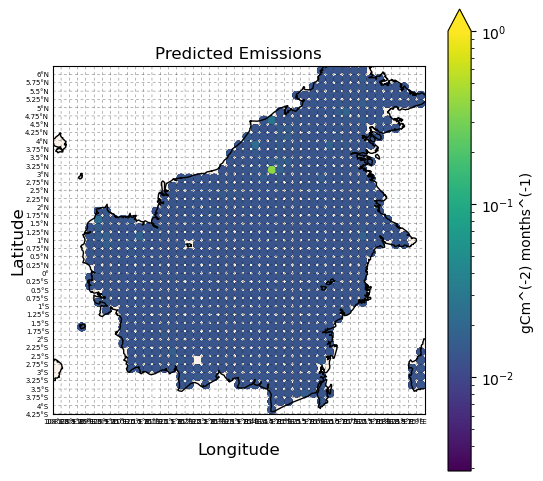

In [ ]:
from matplotlib import colors
from mpl_toolkits.basemap import Basemap, cm
drawmap(pred['longitude'],
        pred['latitude'],
        pred['emissions'],
        "Predicted Emissions",
        "gCm^(-2) months^(-1)")

In [ ]:
y_test

[array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]),
 array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  1.8361307 ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , 27.225805  ,
        36.58278   ,  8.335547  ,  0.3891138 , 10.887282  ,  9.852483  ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        , 93.37941   ,  2.3492746 ,  2.3030672 ,  0.        ,
         3.6692216 ,  0.501592  ,  0.73870826,  0.        ,  0.        ,
         0.        ]),
 array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.63546383, 3.5621777 ,
        0.4721228 , 0.        , 0.        , 0.        , 2.6018217 ,
        0.        , 0.  

In [ ]:
# pred = pd.read_csv('C:/Akmal/Telyu/Telyu/TA/predicted emissions(not normalize).csv')

In [ ]:
y_test=np.array(y_test)

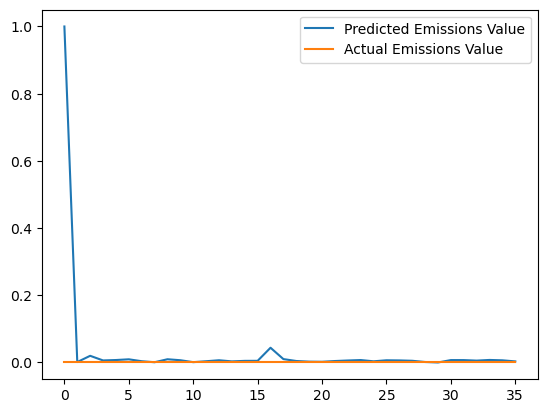

In [ ]:
pyplot.plot(pred['emissions'], label='Predicted Emissions Value')
pyplot.plot(y_test, label='Actual Emissions Value')
pyplot.legend()
pyplot.show()